**Why EfficientNet-B0?**

For this experiment, EfficientNet-B0 was selected due to its strong balance between accuracy and computational efficiency. Unlike heavier CNN architectures, EfficientNet scales depth, width, and resolution in a structured way (compound scaling), which makes it ideal for medical waveform images where fine-grained details matter but training resources are limited.
Additionally, the availability of high-quality pretrained ImageNet weights allows the model to generalize well even with a relatively small dataset, making it a suitable choice for early experimentation and benchmarking.

In [31]:
%%capture
%run pre_processing2.ipynb




In [33]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


Load EfficientNet_B0

In [35]:
weights = EfficientNet_B0_Weights.IMAGENET1K_V1
model = efficientnet_b0(weights=weights)


In [36]:
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, NUM_CLASSES)

In [37]:
for param in model.features.parameters():
    param.requires_grad = False


In [38]:
model = model.to(device)

Loss + Optimizer + Class Weights

In [ ]:

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label_id']),
    y=train_df['label_id']
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class Weights:", class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)



Class Weights: tensor([0.8628, 0.8628, 1.1494, 1.1417, 1.1045, 1.1045, 1.0730, 1.0730, 0.8584,
        0.8584, 1.0183, 1.0531])


Train One Epoch Function and Evaluation Function

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()  
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()        
        outputs = model(images)        
        loss = criterion(outputs, labels)
        loss.backward()                
        optimizer.step()               

        running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs, 1)        
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc


In [ ]:
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()   
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc



Loop training

In [ ]:
num_epochs = 15  
best_val_acc = 0.0

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )
    val_loss, val_acc = evaluate(
        model, val_loader, criterion, device
    )

    print(f"Epoch {epoch}/{num_epochs}")
    print(f"  Train  -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"  Val    -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_efficientnet_b0_weighted.pth")

        print("  ✅ New best model saved!")


Epoch 1/15
  Train  -> Loss: 2.3001, Acc: 0.2610
  Val    -> Loss: 2.0765, Acc: 0.4278
  ✅ New best model saved!
Epoch 2/15
  Train  -> Loss: 1.9927, Acc: 0.4465
  Val    -> Loss: 1.8260, Acc: 0.5436
  ✅ New best model saved!
Epoch 3/15
  Train  -> Loss: 1.7904, Acc: 0.5262
  Val    -> Loss: 1.6434, Acc: 0.5929
  ✅ New best model saved!
Epoch 4/15
  Train  -> Loss: 1.6423, Acc: 0.5692
  Val    -> Loss: 1.5049, Acc: 0.6216
  ✅ New best model saved!
Epoch 5/15
  Train  -> Loss: 1.5399, Acc: 0.5871
  Val    -> Loss: 1.4323, Acc: 0.6330
  ✅ New best model saved!
Epoch 6/15
  Train  -> Loss: 1.4657, Acc: 0.5994
  Val    -> Loss: 1.3293, Acc: 0.6571
  ✅ New best model saved!
Epoch 7/15
  Train  -> Loss: 1.3896, Acc: 0.6174
  Val    -> Loss: 1.2572, Acc: 0.6904
  ✅ New best model saved!
Epoch 8/15
  Train  -> Loss: 1.3393, Acc: 0.6306
  Val    -> Loss: 1.1975, Acc: 0.6823
Epoch 9/15
  Train  -> Loss: 1.2821, Acc: 0.6419
  Val    -> Loss: 1.1627, Acc: 0.7007
  ✅ New best model saved!
Epoch 10/

The training logs show a clear and consistent improvement across epochs, with validation accuracy steadily rising and the best model being updated multiple times. This confirms stable convergence and strong learning behavior throughout the training process.

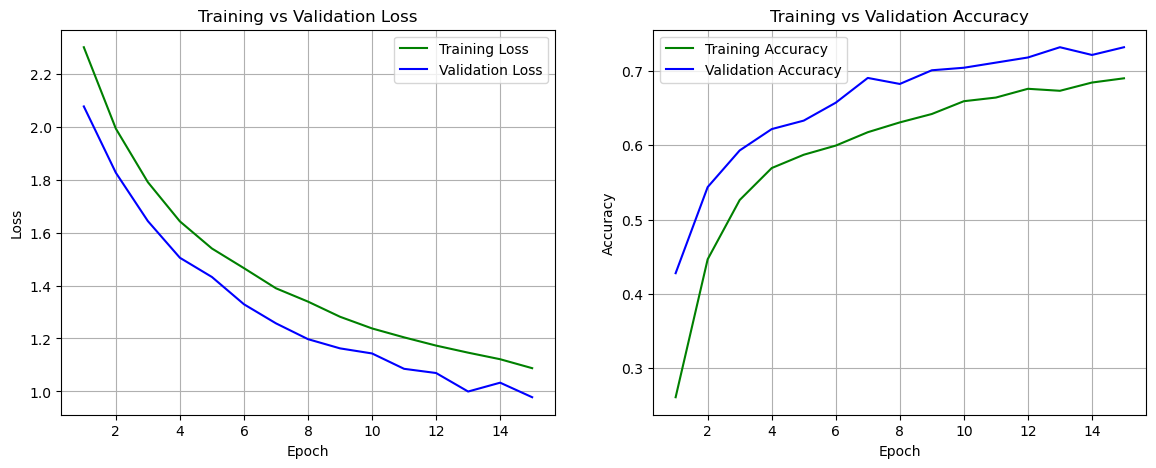

In [43]:
train_losses = [
    2.3001,1.9927,1.7904,1.6423,1.5399,
    1.4657, 1.3896, 1.3393, 1.2821, 1.2380,
    1.2043, 1.1732, 1.1465, 1.1217, 1.0879
]

val_losses = [
    2.0765,1.8260,1.6434,1.5049,1.4323,
    1.3293,1.2572,1.1975,1.1627,1.1435,
    1.0855,1.0696,0.9997,1.0331,0.9782
]

train_accuracies = [
    0.2610,0.4465,0.5262,0.5692,0.5871,
    0.5994,0.6174,0.6306,0.6419,0.6591,
    0.6640,0.6758,0.6731,0.6842,0.6899
]

val_accuracies = [
    0.4278,0.5436,0.5929,0.6216,0.6330,
    0.6571,0.6904,0.6823,0.7007,0.7041,
    0.7110,0.7179,0.7317,0.7213,0.7317
]


import matplotlib.pyplot as plt
import seaborn as sns


epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 5))

# ===== Loss Plot =====
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='green')
plt.plot(epochs, val_losses, label='Validation Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# ===== Accuracy Plot =====
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='green')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.show()


As the figure shows, there is no underfitting or overfitting. Both the accuracy and loss curves improve smoothly, with the validation performance consistently following the training trend, indicating stable and effective learning.

Evaluation on Test Set

In [ ]:
import torch

best_model = model   
state_dict = torch.load("best_efficientnet_b0_weighted.pth", map_location=device)
best_model.load_state_dict(state_dict)
best_model.to(device)

test_loss, test_acc = evaluate(best_model, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Test Loss: 1.0383
Test Accuracy: 0.7194


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


best_model = model
state_dict = torch.load("best_efficientnet_b0_weighted.pth", map_location=device)
best_model.load_state_dict(state_dict)
best_model.to(device)
best_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)

        outputs = best_model(imgs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())


print("\nClassification Report:")
print(classification_report(all_labels, all_preds))



Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.67      0.73        85
           1       0.73      0.69      0.71        85
           2       0.71      0.62      0.66        63
           3       0.63      0.59      0.61        63
           4       0.71      0.91      0.80        65
           5       0.70      0.88      0.78        65
           6       0.86      0.75      0.80        68
           7       0.88      0.87      0.87        68
           8       0.73      0.69      0.71        85
           9       0.82      0.68      0.74        85
          10       0.66      0.75      0.70        72
          11       0.48      0.57      0.52        69

    accuracy                           0.72       873
   macro avg       0.72      0.72      0.72       873
weighted avg       0.73      0.72      0.72       873



**Summary:**  
The classification report shows stable and balanced performance across the classes, with an overall F1-score of ~0.72, indicating that the model is effectively capturing the waveform patterns.


In [46]:
true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

cm = confusion_matrix(true_labels, predicted_labels)


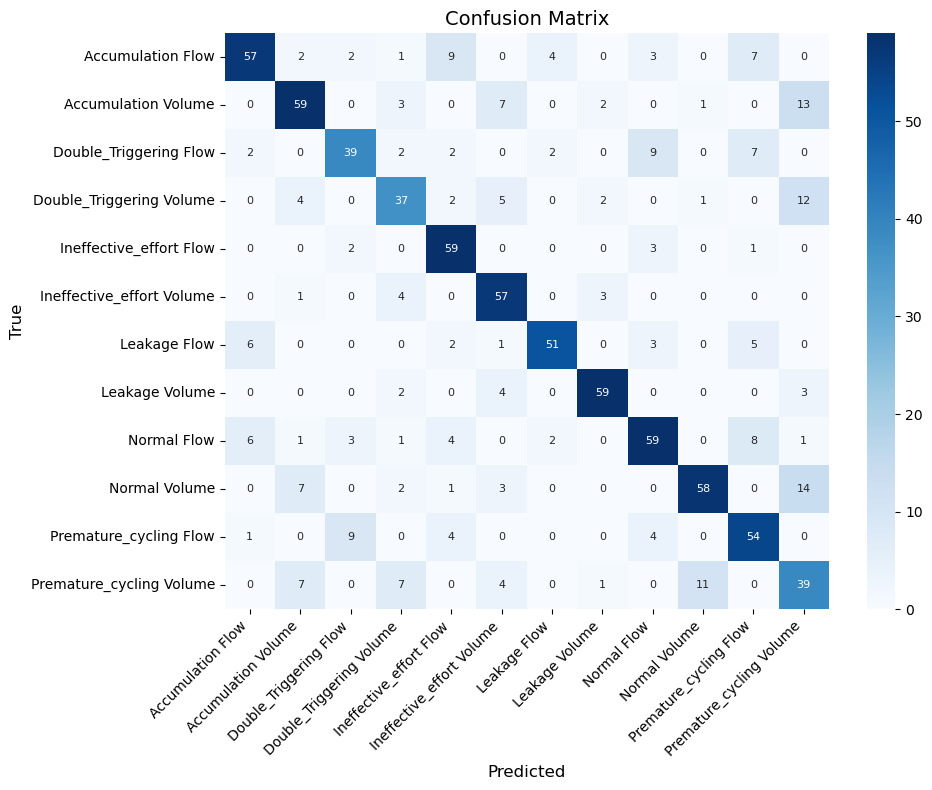

In [ ]:
plt.figure(figsize=(10, 8))

sns.heatmap(
    cm,
    annot=True,          
    fmt="d",             
    cmap="Blues",        
    xticklabels=CLASSES,
    yticklabels=CLASSES,
    annot_kws={"size": 8}   
)

plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()


**Observation & Conclusion:**  
The confusion matrix shows a clear diagonal pattern, indicating that EfficientNet-B0 is making consistent and correct predictions across most waveform classes. These results form a strong baseline that we will use to compare against the ResNet model in the next stage.
